In [58]:
import sys
import os 
import numpy as np 
import torch
import pandas as pd 
import seaborn as sns
sys.path.append('../../')  # Add parent directory to Python path
import matplotlib.pyplot as plt
from main import FileParser, prepare_arg
from src.trainer.stat import StaticTrainer_VX


config_files = [
    'config/compressible/bluff/small_ps.json',
]

def as_abs_path(_path):
    if not os.path.isabs(_path):
        _path = os.path.join(
            os.path.abspath(os.path.dirname(os.path.dirname(os.getcwd()))),
            _path
            )
    return _path

args = [FileParser(as_abs_path(config_file)).parse_args() for config_file in config_files]

arg = args[0]

setattr(arg.path, "result_path", ".results/paper/compressible/bluff/bluff_test.png")
setattr(arg.setup, "train", False)
setattr(arg.setup, "test", True)
setattr(arg.dataset, "batch_size", 256)
setattr(arg.dataset, "rand_dataset", False)
arg = prepare_arg(arg)

t = StaticTrainer_VX(arg)
t.load_ckpt()

Loading and preprocessing data...
Computing statistics and normalizing data
You need to make sure that the u_mean and u_std are the same for testing other datasets!
Preparing for graph building...
Starting Graph Build ...
Skipping Train/Validation graph build as setup_config.train is False.
Graph building took 59.62 s!
Number of parameters: 5626065


/cluster/work/math/shiwen/GOAT/demo/ce_data/../../src/trainer/utils/train_setup.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.path import Path
from matplotlib.ticker import MaxNLocator # 导入 MaxNLocator
from typing import Union, List, Optional, Tuple

# Dummy definitions for external constants if not defined elsewhere
# These should be replaced with your actual definitions
SCATTER_SETTINGS = {'s': 10, 'edgecolor': 'none', 'marker': '.'} 
HATCH_SETTINGS = {'hatch': '////', 'alpha': 0.05, 'facecolor': 'lightgray', 'edgecolor': 'gray'}
CMAP_WRB = "coolwarm" # Example: blue-white-red colormap for errors

def plot_estimates_bluff_modified(
    u_inp: np.ndarray,
    u_gtr: np.ndarray,
    u_prd: np.ndarray,
    x_inp: np.ndarray,
    x_out: np.ndarray,
    shape_path: str,
    symmetric: Union[bool, List[bool]] = True,
    names: Optional[List[str]] = None,
    domain: Tuple[List[float], List[float]] = ([0, 0], [1, 1]),
) -> plt.Figure:
    """
    Plots input data, ground-truth, model predictions, and absolute errors over a 2D domain.
    All plots (Input, Ground-truth, Model estimate, Absolute error) will show data OUTSIDE 
    the specified shape. The Absolute error plot will NOT have a colorbar.
    The Input colorbar will have a reduced number of ticks.

    The number of rows is determined by u_inp.shape[-1] (number of input variables).
    u_gtr and u_prd are assumed to have a single output variable (shape[-1] == 1).

    For each input variable (each row):
    1) Input data channel from u_inp (outside shape).
    2) Ground-truth (u_gtr[:, 0]) (outside shape).
    3) Model prediction (u_prd[:, 0]) (outside shape).
    4) Absolute error (|u_gtr[:, 0] - u_prd[:, 0]|) (outside shape, no colorbar).

    Parameters
    ----------
    u_inp : np.ndarray
        Input data array, shape (N_inp, n_input_vars). Each of n_input_vars gets a row.
    u_gtr : np.ndarray
        Ground-truth data, shape (N_out, 1). Assumes 1 output channel.
    u_prd : np.ndarray
        Model-predicted data, shape (N_out, 1).
    x_inp : np.ndarray
        Coordinates for input data, shape (N_inp, 2). Used for u_inp tricontourf.
    x_out : np.ndarray
        Coordinates for output data, shape (N_out, 2). Used for error scatter plot.
    shape_path : str
        Path to the shape file defining the airfoil. Masking is applied relative to this shape.
    symmetric : bool or list of bool, optional
        Symmetry for color scales. Defaults to True.
    names : list of str, optional
        Names for input variables.
    domain : tuple of list, optional
        Plotting region. Defaults to ([0, 0], [1, 1]).

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure containing the subplots.
    """
    # Load shape data for masking
    with open(shape_path, "r") as file:
        lines = file.readlines()
    
    shape_coords = []
    for line in lines:
        try: 
            x, y = map(float, line.split())
            shape_coords.append((x, y))
        except ValueError:
            continue
    
    shape_data_np = np.array(shape_coords)
    polygon_path = None
    if shape_data_np.ndim == 2 and shape_data_np.shape[1] == 2 and shape_data_np.shape[0] >=3:
        polygon_path = Path(shape_data_np)
    else:
        print(f"Warning: Shape data from {shape_path} could not be parsed into a valid polygon "
              f"(found {shape_data_np.shape[0]} points). Masking will be skipped for all plots.")

    # Triangulation for input grid (x_inp)
    triang = tri.Triangulation(x_inp[:, 0], x_inp[:, 1])
    
    if polygon_path:
        # Create mask for tricontourf (Input, GTR, PRD) to show OUTSIDE the polygon.
        # Mask triangles whose center is INSIDE the polygon.
        mask_for_outside_display = np.zeros(triang.triangles.shape[0], dtype=bool)
        for i, triangle_indices in enumerate(triang.triangles):
            pts = x_inp[triangle_indices]
            center = np.mean(pts, axis=0)
            if polygon_path.contains_point(center): # Mask if center IS INSIDE polygon
                mask_for_outside_display[i] = True
        triang.set_mask(mask_for_outside_display)

    _HEIGHT_PER_ROW = 1.9
    _HEIGHT_MARGIN = .2
    _SCATTER_SETTINGS = SCATTER_SETTINGS.copy()
    _SCATTER_SETTINGS['s'] = _SCATTER_SETTINGS['s'] * .4 * _HEIGHT_PER_ROW 
    if x_inp.shape[0] > 0: 
        _SCATTER_SETTINGS['s'] = _SCATTER_SETTINGS['s'] * 128 / (x_inp.shape[0] ** .5)
    
    n_rows = u_inp.shape[-1]

    if u_gtr.ndim == 1: u_gtr = u_gtr[:, np.newaxis]
    if u_prd.ndim == 1: u_prd = u_prd[:, np.newaxis]
        
    if u_gtr.shape[-1] != 1 or u_prd.shape[-1] != 1:
        raise ValueError(
            f"u_gtr and u_prd are expected to have 1 output channel (shape[-1] == 1). "
            f"Got u_gtr.shape: {u_gtr.shape}, u_prd.shape: {u_prd.shape}"
        )

    if isinstance(symmetric, bool):
        symmetric_flags = [symmetric] * n_rows
    elif len(symmetric) == n_rows:
        symmetric_flags = symmetric
    else:
        print(f"Warning: Length of 'symmetric' list ({len(symmetric)}) != n_rows ({n_rows}). Defaulting to True.")
        symmetric_flags = [True] * n_rows
    
    if names and len(names) != n_rows:
        print(f"Warning: Length of 'names' list ({len(names)}) != n_rows ({n_rows}). Defaulting to generic names.")
        names = None

    figsize = (8.6, _HEIGHT_PER_ROW * n_rows + _HEIGHT_MARGIN)
    fig = plt.figure(figsize=figsize)
    g_fig = fig.add_gridspec(nrows=n_rows, ncols=1, wspace=0, hspace=0.05) 

    u_gtr_on_output_grid = u_gtr[:, 0]
    u_prd_on_output_grid = u_prd[:, 0]
    
    u_gtr_for_triplot = u_gtr_on_output_grid 
    u_prd_for_triplot = u_prd_on_output_grid

    if u_gtr_for_triplot.shape[0] != x_inp.shape[0]:
        print(f"Warning: u_gtr data for tricontourf ({u_gtr_for_triplot.shape[0]} pts) "
              f"mismatches x_inp triangulation ({x_inp.shape[0]} pts).")
    if u_prd_for_triplot.shape[0] != x_inp.shape[0]:
         print(f"Warning: u_prd data for tricontourf ({u_prd_for_triplot.shape[0]} pts) "
              f"mismatches x_inp triangulation ({x_inp.shape[0]} pts).")

    vmax_gtr_overall = np.max(u_gtr_for_triplot) if u_gtr_for_triplot.size > 0 else 0
    vmax_prd_overall = np.max(u_prd_for_triplot) if u_prd_for_triplot.size > 0 else 0
    vmax_out_overall = max(vmax_gtr_overall, vmax_prd_overall)
    
    vmin_gtr_overall = np.min(u_gtr_for_triplot) if u_gtr_for_triplot.size > 0 else 0
    vmin_prd_overall = np.min(u_prd_for_triplot) if u_prd_for_triplot.size > 0 else 0
    vmin_out_overall = min(vmin_gtr_overall, vmin_prd_overall)
    
    abs_vmax_out_overall = max(np.abs(vmax_out_overall), np.abs(vmin_out_overall))

    if u_gtr_on_output_grid.shape[0] != x_out.shape[0] or u_prd_on_output_grid.shape[0] != x_out.shape[0]:
        print(f"Warning: Mismatch between u_gtr/u_prd point count ({u_gtr_on_output_grid.shape[0]}) "
              f"and x_out point count ({x_out.shape[0]}). Error calculation might be incorrect.")
    
    u_err_on_output_grid = u_gtr_on_output_grid - u_gtr_on_output_grid
    abs_u_err_on_output_grid = np.abs(u_err_on_output_grid)
    max_abs_err_for_plot = np.max(abs_u_err_on_output_grid) if abs_u_err_on_output_grid.size > 0 else 0

    row_subfigures = []
    axs_all_inp, axs_all_gtr, axs_all_prd, axs_all_err = [], [], [], []
    axs_all_cb_inp, axs_all_cb_out, axs_all_cb_err = [], [], [] # axs_all_cb_err will be created but hidden

    for i_row in range(n_rows):
        subfig = fig.add_subfigure(g_fig[i_row], frameon=False)
        row_subfigures.append(subfig)
        
        g_row = subfig.add_gridspec(
            nrows=2, ncols=4, height_ratios=[1, .05],
            wspace=0.20, hspace=0.05,
        )
        axs_all_inp.append(subfig.add_subplot(g_row[0, 0]))
        axs_all_gtr.append(subfig.add_subplot(g_row[0, 1]))
        axs_all_prd.append(subfig.add_subplot(g_row[0, 2]))
        axs_all_err.append(subfig.add_subplot(g_row[0, 3]))
        axs_all_cb_inp.append(subfig.add_subplot(g_row[1, 0]))
        axs_all_cb_out.append(subfig.add_subplot(g_row[1, 1:3])) 
        axs_all_cb_err.append(subfig.add_subplot(g_row[1, 3])) # Axis for error colorbar (will be hidden)

    for ax_list in [axs_all_inp, axs_all_gtr, axs_all_prd, axs_all_err]:
        for ax in ax_list:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlim([domain[0][0], domain[1][0]])
            ax.set_ylim([domain[0][1], domain[1][1]])
            ax.fill_between( 
                x=[domain[0][0], domain[1][0]], y1=domain[0][1], y2=domain[1][1],
                **HATCH_SETTINGS,
            )

    for i_row in range(n_rows):
        u_inp_current_var = u_inp[:, i_row] 

        vmax_inp_local = np.max(u_inp_current_var) if u_inp_current_var.size > 0 else 0
        vmin_inp_local = np.min(u_inp_current_var) if u_inp_current_var.size > 0 else 0
        abs_vmax_inp_local = max(np.abs(vmax_inp_local), np.abs(vmin_inp_local))
        current_row_symmetric = symmetric_flags[i_row]

        # 1. Plot Input (u_inp[:, i_row]) - shows OUTSIDE polygon
        ax_inp = axs_all_inp[i_row]
        h_inp = ax_inp.tricontourf(
            triang, u_inp_current_var, levels=200, cmap="jet", 
            vmax=(abs_vmax_inp_local if current_row_symmetric else vmax_inp_local),
            vmin=(-abs_vmax_inp_local if current_row_symmetric else vmin_inp_local),
        )
        cb_inp = plt.colorbar(h_inp, cax=axs_all_cb_inp[i_row], orientation='horizontal')
        cb_inp.formatter.set_powerlimits((0, 0))
        cb_inp.locator = MaxNLocator(nbins=5) # 设置Input colorbar的最大刻度数量
        cb_inp.update_ticks() # 更新刻度以应用MaxNLocator

        # 2. Plot Ground Truth (u_gtr_for_triplot) - shows OUTSIDE polygon
        ax_gtr = axs_all_gtr[i_row]
        h_gtr = ax_gtr.tricontourf(
            triang, u_gtr_for_triplot, levels=200, cmap="jet", 
            vmax=(abs_vmax_out_overall if current_row_symmetric else vmax_out_overall),
            vmin=(-abs_vmax_out_overall if current_row_symmetric else vmin_out_overall),
        )
        
        # 3. Plot Prediction (u_prd_for_triplot) - shows OUTSIDE polygon
        ax_prd = axs_all_prd[i_row]
        h_prd = ax_prd.tricontourf(
            triang, u_prd_for_triplot, levels=200, cmap="jet", 
            vmax=(abs_vmax_out_overall if current_row_symmetric else vmax_out_overall),
            vmin=(-abs_vmax_out_overall if current_row_symmetric else vmin_out_overall),
        )
        cb_out = plt.colorbar(h_prd, cax=axs_all_cb_out[i_row], orientation='horizontal')
        cb_out.formatter.set_powerlimits((0, 0))
        # 如果需要，也可以为 cb_out 设置 MaxNLocator
        # cb_out.locator = MaxNLocator(nbins=5) 
        # cb_out.update_ticks()

        # 4. Plot Absolute Error (on x_out grid, masked to show OUTSIDE polygon_path, NO COLORBAR)
        ax_err = axs_all_err[i_row]
        current_x_out_coords = x_out
        data_for_err_scatter = abs_u_err_on_output_grid
        
        if abs_u_err_on_output_grid.shape[0] != current_x_out_coords.shape[0]:
            print(f"Critical Warning: Error data size ({abs_u_err_on_output_grid.shape[0]}) "
                  f"mismatches x_out coordinate size ({current_x_out_coords.shape[0]}). Error plot affected.")
            min_len = min(abs_u_err_on_output_grid.shape[0], current_x_out_coords.shape[0])
            if min_len > 0:
                data_for_err_scatter = abs_u_err_on_output_grid[:min_len]
                current_x_out_coords = current_x_out_coords[:min_len, :]
            elif current_x_out_coords.shape[0] > 0:
                 data_for_err_scatter = np.zeros(current_x_out_coords.shape[0])
            else:
                 data_for_err_scatter = np.array([])
                 current_x_out_coords = np.empty((0,2))
        
        # Filter points for the error scatter plot to be OUTSIDE the polygon
        filtered_x_out_for_err = current_x_out_coords
        filtered_data_for_err_scatter = data_for_err_scatter

        if polygon_path and current_x_out_coords.shape[0] > 0:
            # This mask is for points OUTSIDE the polygon
            points_outside_polygon_mask_for_error = ~polygon_path.contains_points(current_x_out_coords)
            filtered_x_out_for_err = current_x_out_coords[points_outside_polygon_mask_for_error]
            filtered_data_for_err_scatter = data_for_err_scatter[points_outside_polygon_mask_for_error]
        
        if filtered_x_out_for_err.shape[0] > 0 : 
            ax_err.scatter(
                x=filtered_x_out_for_err[:, 0], y=filtered_x_out_for_err[:, 1], 
                c=filtered_data_for_err_scatter,
                cmap=CMAP_WRB, vmin=0, vmax=max_abs_err_for_plot, 
                **_SCATTER_SETTINGS,
            )

        # Hide the axis intended for the error colorbar
        axs_all_cb_err[i_row].set_visible(False)

        label = names[i_row] if names and i_row < len(names) else f'Input Var. {i_row:02d}'
        ax_inp.set_ylabel(label, fontsize=9) 

    if n_rows > 0:
        axs_all_inp[0].set_title('Input', fontsize=10)
        axs_all_gtr[0].set_title('Ground-truth', fontsize=10)
        axs_all_prd[0].set_title('Model estimate', fontsize=10)
        axs_all_err[0].set_title('Point distribution', fontsize=10)

    # Adjust colorbar tick label formatting loop to exclude error colorbar axes
    for ax_cb_list in [axs_all_cb_inp, axs_all_cb_out]: # axs_all_cb_err removed
        for ax_cb in ax_cb_list:
            ax_cb.xaxis.get_offset_text().set_fontsize(7) 
            ax_cb.tick_params(axis='x', labelsize=7) 

    return fig



In [60]:
from src.trainer.stat import move_to_device

t.model.eval()
t.model.to(t.device)
with torch.no_grad():

    x_batch , y_batch, coord_batch, encoder_graph_batch, decoder_graph_batch = next(iter(t.test_loader))
    x_batch, y_batch, coord_batch = x_batch.to(t.device), y_batch.to(t.device), coord_batch.to(t.device)
    encoder_graph_batch = move_to_device(encoder_graph_batch, t.device)
    decoder_graph_batch = move_to_device(decoder_graph_batch, t.device)
    latent_tokens_coord = t.latent_tokens_coord.to(t.device)

    pred = t.model(
        latent_tokens_coord = latent_tokens_coord,
        xcoord = coord_batch,
        pndata = x_batch,
        encoder_nbrs = encoder_graph_batch,
        decoder_nbrs = decoder_graph_batch
    )


In [61]:
from src.trainer.utils.cal_metric import compute_batch_errors

pred_de_norm = pred * t.u_std.to(t.device) + t.u_mean.to(t.device)
y_batch_de_norm = y_batch * t.u_std.to(t.device) + t.u_mean.to(t.device)
x_batch_de_norm = x_batch * t.c_std.to(t.device) + t.c_mean.to(t.device)

relative_errors = compute_batch_errors(y_batch_de_norm, pred_de_norm, t.metadata)
print(f"relative errors: {relative_errors}")
print("shape of pred:", pred_de_norm.shape)
print("shape of truth", y_batch_de_norm.shape)
print("shape of input", x_batch_de_norm.shape)
print("shape of the coord", coord_batch.shape)


relative errors: tensor([[0.0351]], device='cuda:0')
shape of pred: torch.Size([256, 14000, 1])
shape of truth torch.Size([256, 14000, 1])
shape of input torch.Size([256, 14000, 3])
shape of the coord torch.Size([256, 14000, 2])


Mach: 0.9000000357627869, AOA:7.0


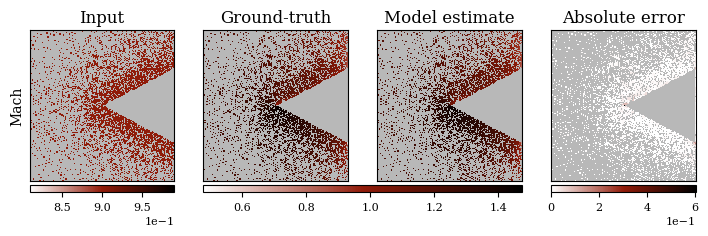

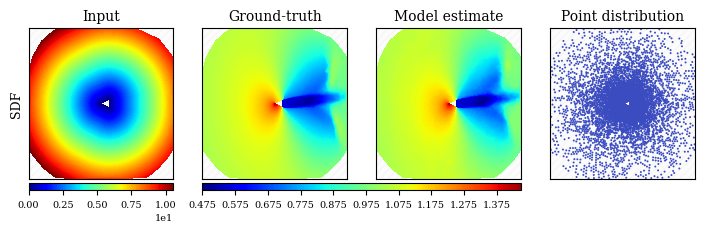

In [78]:
from src.trainer.utils.plot import plot_estimates, plot_estimates_bluff

ind = -11
shape_path = "/cluster/work/math/camlab-data/unstruct_data/bluff_unstruct/bluff_shapes/cone_small.dat"
#"/cluster/work/math/camlab-data/unstruct_data/airfoil_unstruct/naca_series/af_shape/naca2412/naca2412_500.dat"
#shape_path = "/cluster/work/math/camlab-data/graphnpde/bluff_unstruc/shape/rectangle_small.dat"
print(f"Mach: {x_batch_de_norm[ind][0,0]}, AOA:{x_batch_de_norm[ind][0,1]}")
coord_origin = t.test_loader.dataset.x_data.squeeze(1)

plot_estimates(
    u_inp = x_batch_de_norm[ind].cpu().numpy(),
    u_gtr = y_batch_de_norm[ind].cpu().numpy(),
    u_prd = pred_de_norm[ind].cpu().numpy(),
    x_inp = coord_origin[ind].cpu().numpy(),
    x_out = coord_origin[ind].cpu().numpy(),
    names = t.metadata.names["c"],
    symmetric = t.metadata.signed["u"],
    domain = [(-1, -1), [1, 1]]
)

fig = plot_estimates_bluff_modified(
    u_inp = x_batch_de_norm[ind][:,2:3].cpu().numpy(),
    u_gtr = y_batch_de_norm[ind].cpu().numpy(),
    u_prd = pred_de_norm[ind].cpu().numpy(),
    x_inp = coord_origin[ind].cpu().numpy(),
    x_out = coord_origin[ind].cpu().numpy(),
    shape_path = shape_path,
    names = [t.metadata.names["c"][-1]],
    symmetric = [False],#t.metadata.signed["u"],
    domain = t.metadata.domain_x
)

fig.savefig(t.path_config.result_path)